In [1]:
import functools
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

import e3x
import flax.linen as nn
import jax

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.local_devices()
print(devices)

import jax.numpy as jnp
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.set_cmap('bwr')
# from jax.config import config
# config.update("jax_debug_nans", True)

[CudaDevice(id=0)]


<Figure size 640x480 with 0 Axes>

In [2]:
jax.default_backend()
jax.devices()

[CudaDevice(id=0)]

In [3]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

2025-07-23 10:36:10.172968: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.93. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [41]:
def prepare_datasets(key, num_train, num_valid, filename="esp2000.npz"):
  # Load the dataset.
  dataset = np.load(filename)
    
  for k,v in dataset.items():
      print(k, v.shape)

  # nonzeros = np.arange(0, num_train)
  # dataF =   dataset['F'][nonzeros]
  dataR =   dataset['R']#[nonzeros]
  dataZ =   dataset['Z']#[nonzeros]
  dataMono =   dataset['mono']#[nonzeros]
  # dataDip = dataset['dip'][nonzeros]
  dataEsp = dataset["esp"]#[nonzeros]
  dataVDW = dataset["vdw_surface"]#[nonzeros]
  dataNgrid =  dataset["n_grid"]#[nonzeros]
  # dataset['F'] =   dataset['F'][nonzeros]
    
  # Make sure that the dataset contains enough entries.
  num_data = len(dataR)
  print(num_data)
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # atomic_numbers = jnp.tile(dataset['z'], num_data).reshape((num_data, len(dataset["z"])))
  atomic_numbers = dataZ
    
  # Determine mean energy of the training set.
  # mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000
  mean_energy = 0

  # Collect and return train and validation sets.
  train_data = dict(
    # energy=jnp.asarray(dataset['E'][train_choice] - mean_energy),
    # forces=jnp.asarray(dataF[train_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[train_choice]),
    ngrid = jnp.array(dataNgrid[train_choice]),
    positions=jnp.asarray(dataR[train_choice]),
    mono=jnp.asarray(dataMono[train_choice]),
    # dipo=jnp.asarray(dataDip[train_choice]),
    esp=jnp.asarray(dataEsp[train_choice]),
    vdw_surface=jnp.asarray(dataVDW[train_choice]),
  )
  valid_data = dict(
    # energy=jnp.asarray(dataset['E'][valid_choice] - mean_energy),
    # forces=jnp.asarray(dataF[valid_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[valid_choice]),
    positions=jnp.asarray(dataR[valid_choice]),
    mono=jnp.asarray(dataMono[valid_choice]),
    # dipo=jnp.asarray(dataDip[valid_choice]),
    ngrid = jnp.array(dataNgrid[valid_choice]),
    esp=jnp.asarray(dataEsp[valid_choice]),
    vdw_surface=jnp.asarray(dataVDW[valid_choice]),
  )
  print("...")
  print("...")
  for k,v in train_data.items():
      print(k, v.shape)
  print("...")
  for k,v in valid_data.items():
      print(k, v.shape)
      
  return train_data, valid_data, mean_energy

In [94]:
prepare_datasets?

Signature: prepare_datasets(key, num_train, num_valid, filename='esp2000.npz')
Docstring: <no docstring>
File:      /tmp/ipykernel_3629/312904792.py
Type:      function

#  Data

In [136]:
old_datafile = "/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-esp-dip-1000-0.npz"
datafile = "/pchem-data/meuwly/boittier/home/dcmnet/snakemake/test.npz"
datasize = 1500

batch_size = 32
train_data, valid_data, mean_energy = prepare_datasets(
    data_key, datasize-batch_size, batch_size,
    filename=datafile,
                                                      )

energy (1983,)
esp (1983, 8000)
R (1983, 18, 3)
Z (1983, 18)
D (1983, 3)
Q (1983, 3, 3)
gradient (1983, 18, 3)
n_grid (1983,)
vdw_surface (1983, 8000, 3)
mono (1983, 18)
1983
...
...
atomic_numbers (1468, 18)
ngrid (1468,)
positions (1468, 18, 3)
mono (1468, 18)
esp (1468, 8000)
vdw_surface (1468, 8000, 3)
...
atomic_numbers (32, 18)
positions (32, 18, 3)
mono (32, 18)
ngrid (32,)
esp (32, 8000)
vdw_surface (32, 8000, 3)


In [137]:
train_data.keys()

dict_keys(['atomic_numbers', 'ngrid', 'positions', 'mono', 'esp', 'vdw_surface'])

#  Model

In [138]:


class MessagePassingModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 17  


  def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, 
                     features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        y = e3x.nn.MessagePass(max_degree=max_degree, include_pseudotensors=False
                              )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
          
      y = e3x.nn.add(x, y)
      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, 
                       # kernel_init=jax.nn.initializers.zeros
                      )(y)
      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic monopoles with an ordinary dense layer.
    atomic_mono = e3x.nn.change_max_degree_or_type(x, 
                                                   max_degree=0, 
                                                   include_pseudotensors=False)
    element_bias = self.param('element_bias', 
                              lambda rng, shape: jnp.zeros(shape), 
                              (self.max_atomic_number+1))
    atomic_mono = nn.Dense(2, use_bias=False,
                           kernel_init=jax.nn.initializers.zeros
                          )(atomic_mono)  
    atomic_mono = atomic_mono.squeeze()
    atomic_mono += element_bias[atomic_numbers][:,None]

    atomic_dipo = e3x.nn.TensorDense(  
        features=2,
        max_degree=1, 
        include_pseudotensors=False,
    )(x)[:,1,1:4,:]

    atomic_dipo = e3x.nn.silu(atomic_dipo)
    atomic_dipo = jnp.clip(atomic_dipo, a_min = -0.3, a_max=0.3) 
    atomic_dipo += positions[:,:,None]

    return atomic_mono, atomic_dipo 


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, 
               batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

In [168]:
def prepare_batches(key, data, batch_size):
  # Determine the number of training steps per epoch.
  data_size = len(data['mono'])
  steps_per_epoch = data_size//batch_size

  # Draw random permutations for fetching batches from the train data.
  perms = jax.random.permutation(key, data_size)
  perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
  perms = perms.reshape((steps_per_epoch, batch_size))

  # Prepare entries that are identical for each batch.
  num_atoms = len(data['atomic_numbers'][0])
  # print(num_atoms)
  batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
  # atomic_numbers = jnp.tile(data['atomic_numbers'], batch_size)
  offsets = jnp.arange(batch_size) * num_atoms
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
  dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
  src_idx = (src_idx + offsets[:, None]).reshape(-1)
  # Assemble and return batches.
  return [
    dict(
        # energy=data['energy'][perm],
        # forces=data['forces'][perm].reshape(-1, 3),
        mono=data["mono"][perm].reshape(-1),
        ngrid = data["ngrid"][perm].reshape(-1),
        esp=data["esp"][perm]/627.509, #.reshape(-1),
        vdw_surface=data["vdw_surface"][perm], #.reshape(-1, 3),
        # dipo=data['dipo'][perm].reshape(-1, 3),
        atomic_numbers=data["atomic_numbers"][perm].reshape(-1),
        positions=data['positions'][perm].reshape(-1, 3),
        dst_idx=dst_idx,
        src_idx=src_idx,
        batch_segments = batch_segments,
    )
    for perm in perms
  ]

In [169]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

1


#  Electrostatics

In [170]:
import jax.numpy as jnp
from jax import jit, grad

def nan_safe_coulomb_potential(q, r):
    potential = jnp.where(jnp.isnan(r) | (r == 0.0), 0.0, q / (r * 1.88973) )
    return potential


In [171]:
def calc_esp(charge_positions, charge_values, grid_positions, mono):
    chg_mask = jnp.where(mono != 0, 1.0, 0.0)
    # Expand the grid positions and charge positions to compute all pairwise differences
    diff = grid_positions[:, None, :] - charge_positions[None, :, :]
    # Compute the Euclidean distance between each grid point and each charge
    r = jnp.linalg.norm(diff, axis=-1)  
    C = nan_safe_coulomb_potential((chg_mask * charge_values)[None,:], r)
    V = jnp.sum(C, axis=-1)
    return V

from jax import vmap

batched_electrostatic_potential = vmap(calc_esp, in_axes=(0, 0, 0, 0), out_axes=0)

In [172]:
NATOMS = 18
i = 0
xyzs = valid_batches[i]["positions"].reshape(batch_size, NATOMS, 3)
monos = valid_batches[i]["mono"].reshape(batch_size, NATOMS)
vdws = valid_batches[i]["vdw_surface"]

print(xyzs.shape)
print(monos.shape)
print(vdws.shape)


(32, 18, 3)
(32, 18)
(32, 8000, 3)


In [173]:
batched_prediction = batched_electrostatic_potential(xyzs, monos, vdws, monos)

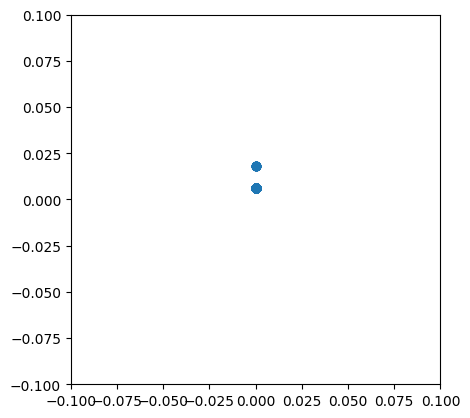

In [174]:
plt.scatter(valid_batches[i]["esp"], batched_prediction)
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)
ax = plt.gca()
ax.set_aspect("equal")

In [175]:
def clip_colors(c):
    return np.clip(c, -0.015, 0.015)

In [176]:
j = 0

(-10.0, 10.0)

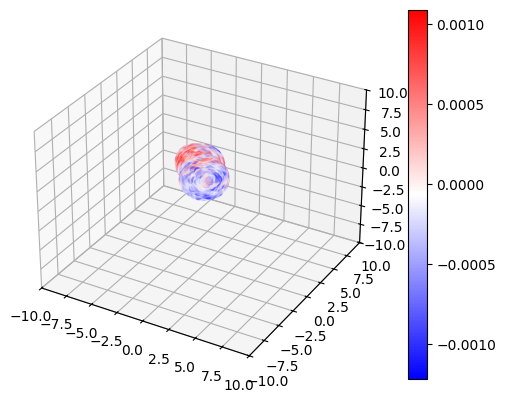

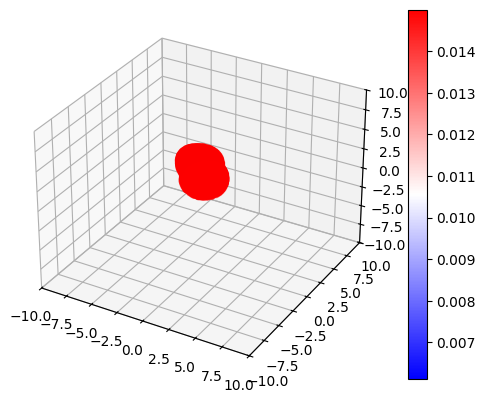

In [177]:
ax = plt.figure().add_subplot(projection='3d')
s = ax.scatter(*vdws[j].T, c=clip_colors(valid_batches[i]["esp"][j]))
plt.colorbar(s)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
ax = plt.figure().add_subplot(projection='3d')
s = ax.scatter(*vdws[j].T, c=clip_colors(batched_prediction[j]))
plt.colorbar(s)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)

#  Parameters

In [178]:
NATOMS = 18

#  Loss

In [179]:
def esp_loss(dipo_prediction, mono_prediction, esp_target, vdw_surface, mono):
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)  
    batched_pred = batched_electrostatic_potential(d, m, vdws, mono)
    l2_loss = optax.l2_loss(batched_pred, esp_target)
    return jnp.mean(l2_loss) #* 627.509**2


In [180]:
@functools.partial(jax.jit, static_argnames=('batch_size'))
def esp_mono_loss(dipo_prediction, mono_prediction, esp_target, 
                  vdw_surface, mono, batch_size):
    """
    """
    nonzero = jnp.nonzero(mono, size=batch_size*18)
    l2_loss_mono = optax.l2_loss(mono_prediction.sum(axis=-1), mono)
    mono_loss = jnp.mean(l2_loss_mono[nonzero])
    
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, 2)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS*2, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), 2, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * 2)  
    
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono).flatten()
    esp_target = esp_target.flatten()
    esp_non_zero = jnp.nonzero(esp_target, size=batch_size*19)
    
    l2_loss = optax.l2_loss(batched_pred, esp_target)
    esp_loss = jnp.mean(l2_loss[esp_non_zero])
    esp_loss = esp_loss * 10000
    return esp_loss + mono_loss*0


In [181]:
def esp_mono_loss_pots(dipo_prediction, mono_prediction, esp_target, 
                       vdw_surface, mono, batch_size):   
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, 2)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS*2, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), 2, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * 2)  
    
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)
    
    return batched_pred

In [182]:
def esp_loss_pots(dipo_prediction, mono_prediction, 
                  esp_target, vdw_surface, mono, batch_size):
    
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)      

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred

In [183]:
def mean_absolute_error(prediction, target, batch_size):
  nonzero = jnp.nonzero(target, size=batch_size*60)
  return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

In [184]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, 
               batch_size, opt_state, params,):
  def loss_fn(params):
    mono, dipo = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
    )
    loss = esp_mono_loss(
      dipo_prediction=dipo,
      mono_prediction=mono,
      vdw_surface=batch['vdw_surface'],
      esp_target=batch['esp'],
      mono=batch['mono'],
      batch_size=batch_size,
    )
    return loss, (mono, dipo)
      
  (loss, (mono, dipo)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, params):
  mono, dipo = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
  loss = esp_mono_loss(
      dipo_prediction=dipo,
      mono_prediction=mono,
      vdw_surface=batch['vdw_surface'],
      esp_target=batch['esp'],
      mono=batch['mono'],
      batch_size=batch_size,
    )
  return loss


def train_model(key, model, train_data, valid_data, 
                num_epochs, learning_rate, batch_size, 
                restart_params = None):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(
      len(train_data['atomic_numbers'][0]))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'][0],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  if restart_params is not None:
      params = restart_params
      
  opt_state = optimizer.init(params)
    
  print("Preparing batches")
  print("..................")
  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)
    # Loop over train batches.
    train_loss = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss = train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        opt_state=opt_state,
        params=params,
      )
      train_loss += (loss - train_loss)/(i+1)
        
    # Evaluate on validation set.
    valid_loss = 0.0
    for i, batch in enumerate(valid_batches):
      loss = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)
           
    # Print progress.
    print(f"epoch: {epoch: 3d}      train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3e} {valid_loss : 8.3e}")

  # Return final model parameters.
  return params, valid_loss

In [185]:
jax.default_backend()
jax.devices()

[CudaDevice(id=0)]

#  Training

In [186]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

# Training hyperparameters.
learning_rate = 0.0001
# batch_size = 32


In [187]:
# Create and train model.
message_passing_model = MessagePassingModel(
  features=features,
  max_degree=max_degree,
  num_iterations=num_iterations,
  num_basis_functions=num_basis_functions,
  cutoff=cutoff,
)

In [188]:
import pandas as pd
# params = pd.read_pickle("0.3-0-0.06512919068336487-esp_params.pkl")

In [ ]:
num_epochs = 2000
params, val = train_model(
      key=train_key,
      model=message_passing_model,
      train_data=train_data,
      valid_data=valid_data,
      num_epochs=num_epochs,
      learning_rate=learning_rate,
      batch_size=batch_size,
      # restart_params=params,
    )
    
import pickle
# open a file, where you want to store the data
with open(f'params-{val}.pkl', 'wb') as file:
    pickle.dump(params, file)
print()

Preparing batches
..................
epoch:   1      train:   valid:
    loss [a.u.]              3.704e-03  1.283e-02
epoch:   2      train:   valid:
    loss [a.u.]              3.877e-03  6.987e-04
epoch:   3      train:   valid:
    loss [a.u.]              1.822e-03  4.983e-03
epoch:   4      train:   valid:
    loss [a.u.]              1.814e-03  8.795e-03
epoch:   5      train:   valid:
    loss [a.u.]              1.321e-03  1.820e-02
epoch:   6      train:   valid:
    loss [a.u.]              2.908e-03  3.336e-02
epoch:   7      train:   valid:
    loss [a.u.]              1.454e-03  1.143e-03
epoch:   8      train:   valid:
    loss [a.u.]              6.931e-04  4.605e-03
epoch:   9      train:   valid:
    loss [a.u.]              5.776e-04  6.780e-04
epoch:  10      train:   valid:
    loss [a.u.]              5.229e-04  2.391e-03
epoch:  11      train:   valid:
    loss [a.u.]              5.232e-04  6.779e-04
epoch:  12      train:   valid:
    loss [a.u.]              

#  Evaluation

In [161]:
def esp_loss_eval(pred, target, ngrid):
    target = target.flatten()
    esp_non_zero = np.nonzero(target)
    l2_loss = optax.l2_loss(pred[esp_non_zero], target[esp_non_zero])
    esp_loss = np.mean(l2_loss)
    esp_loss = esp_loss * 1  
    return esp_loss

In [162]:
def clip_colors(c):
    return np.clip(c, -0.015, 0.015)

In [163]:
def evaluate_dc(batch, dipo, mono, batch_size):
    esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                             batch['vdw_surface'], batch['mono'], 
                             batch_size)

    mono_pred =  esp_loss_pots(batch['positions'], batch['mono'], batch['esp'],
                        batch['vdw_surface'], batch['mono'], batch_size)

    non_zero = np.nonzero(batch["mono"])
    plt.scatter(batch["mono"][non_zero], 
                mono.sum(axis=-1).squeeze()[non_zero])
    loss = esp_loss_eval(batch["mono"][non_zero], mono.sum(axis=-1).squeeze()[non_zero], None)
    plt.title(loss)
    plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    ax=plt.gca()
    ax.set_aspect("equal")
    plt.show()
    
    for id in range(batch_size):
        plt.scatter(esp_dc_pred[id][:batch['ngrid'][id]],
                    batch['esp'][id][:batch['ngrid'][id]], alpha=0.1, label=i)
 
    # plt.legend(columns=5)
    ax = plt.gca()
    plt.xlim(-0.15, 0.15)
    plt.ylim(-0.15, 0.15)
    plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
    ax.set_aspect("equal")
    plt.show()
    
    for mbID in range(batch_size):
        fig = plt.figure(figsize=(12,6))
        
        ax1 = fig.add_subplot(331, projection='3d')
        s = ax1.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]].T, 
                       c=clip_colors(batch['esp'][mbID][:batch['ngrid'][mbID]]), 
                       vmin=-0.015, vmax=0.015)
        ax1.set_title(f"GT {mbID}")
        
        loss = esp_loss_eval(esp_dc_pred[mbID][:batch['ngrid'][mbID]], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]],
                      batch['ngrid'][mbID])
        ax2 = fig.add_subplot(332, projection='3d')
        s = ax2.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]].T, 
                       c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]]), 
                       vmin=-0.015, vmax=0.015)
        ax2.set_title(loss)

        loss = esp_loss_eval(mono_pred[mbID][:batch['ngrid'][mbID]], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]],
                      batch['ngrid'][mbID])
        ax3 = fig.add_subplot(333, projection='3d')
        s = ax3.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]].T, 
                       c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]]), 
                       vmin=-0.015, vmax=0.015)
        ax3.set_title(loss)

        for _ in [ax1,ax2,ax3]:
            _.set_xlim(-10,10)
            _.set_ylim(-10,10)
            _.set_zlim(-10,10)
        plt.show()


In [164]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

1


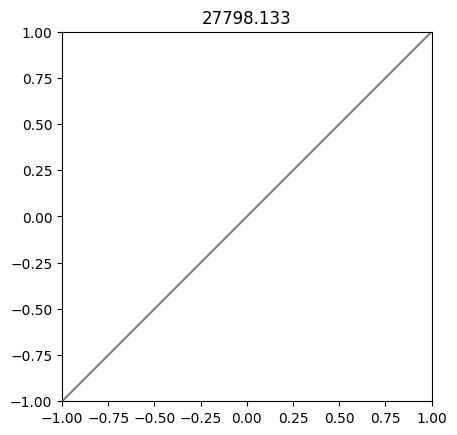

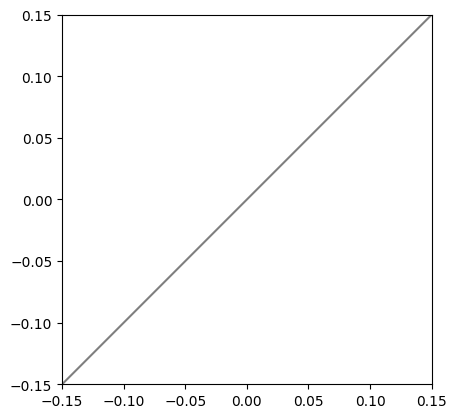

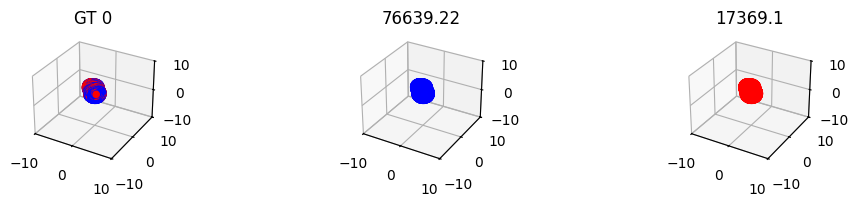

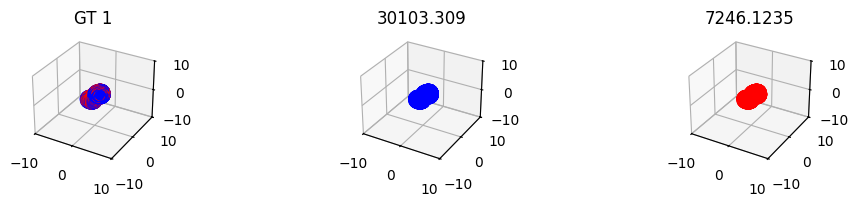

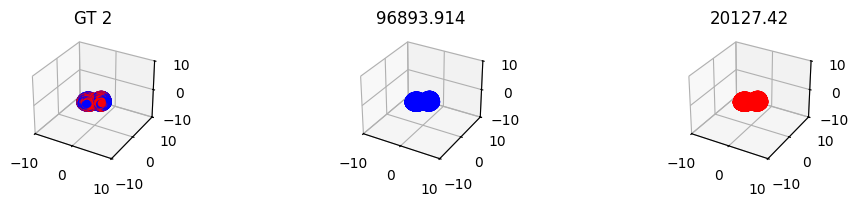

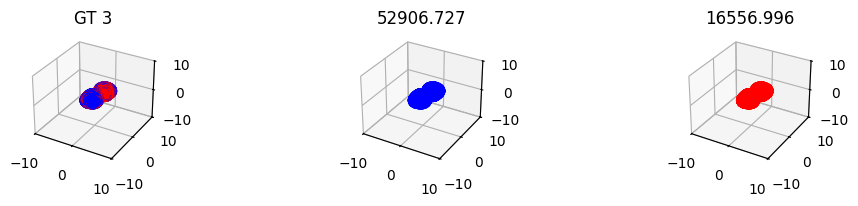

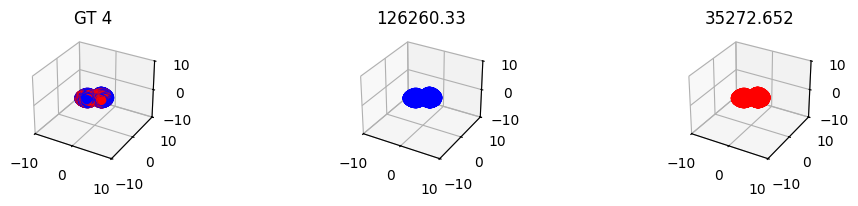

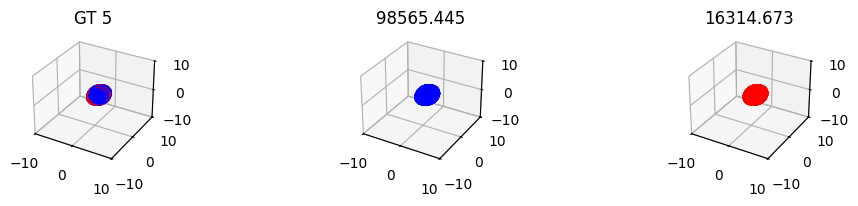

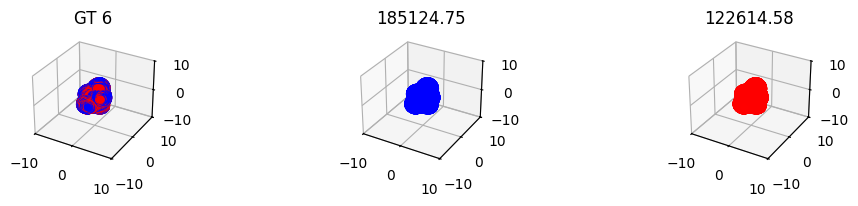

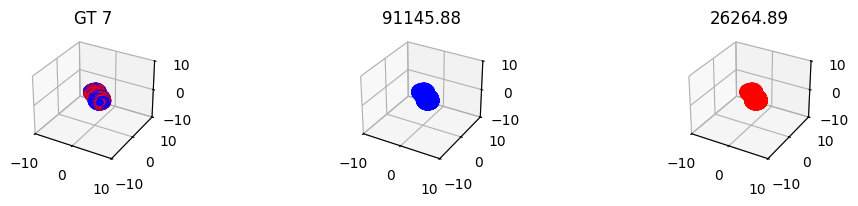

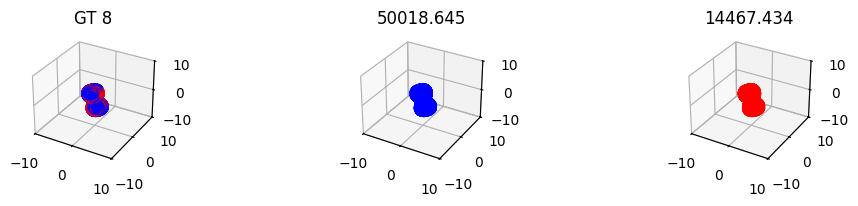

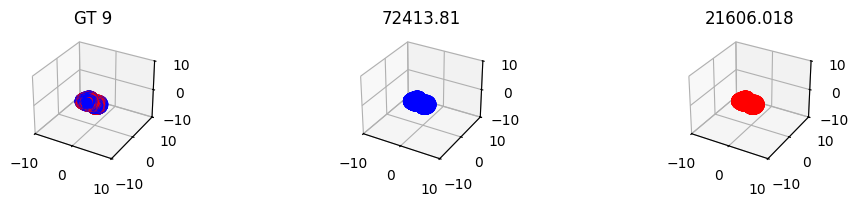

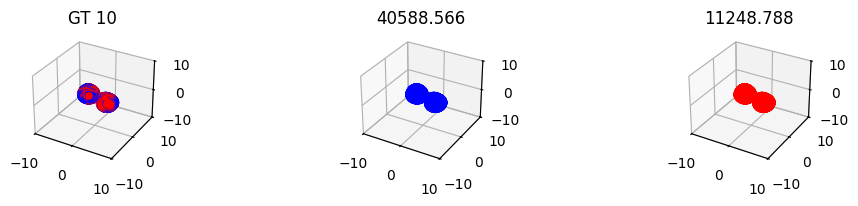

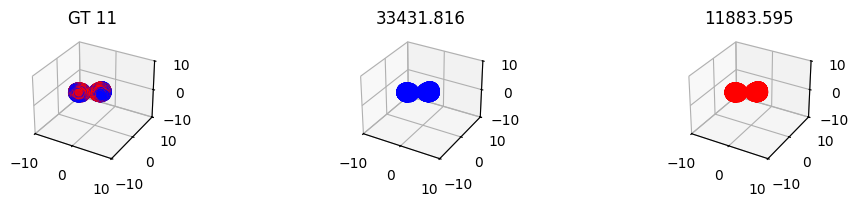

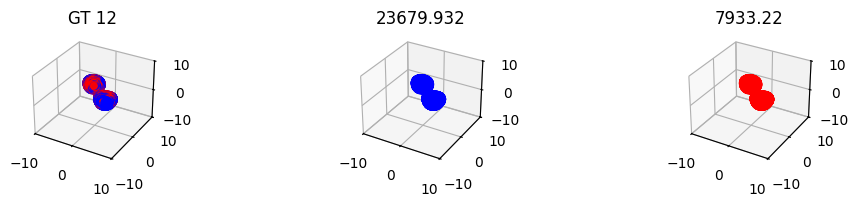

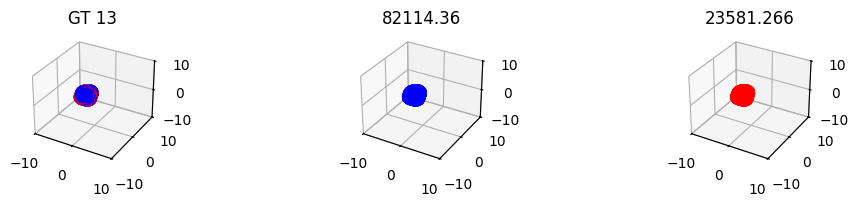

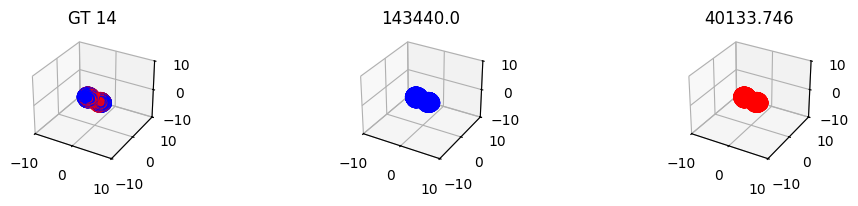

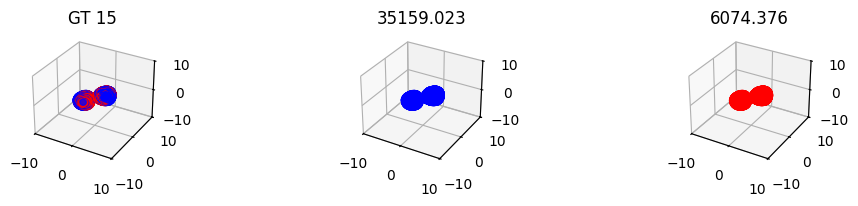

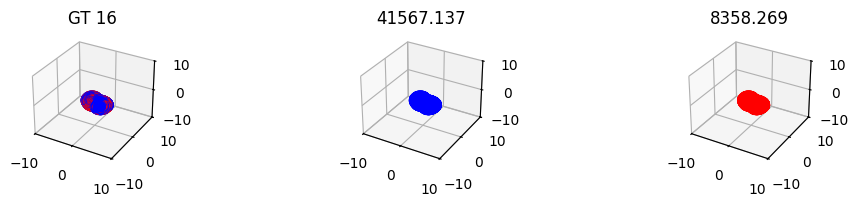

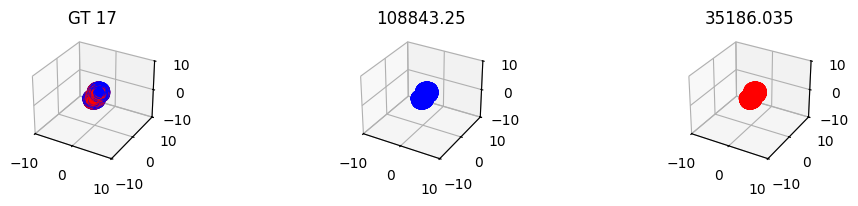

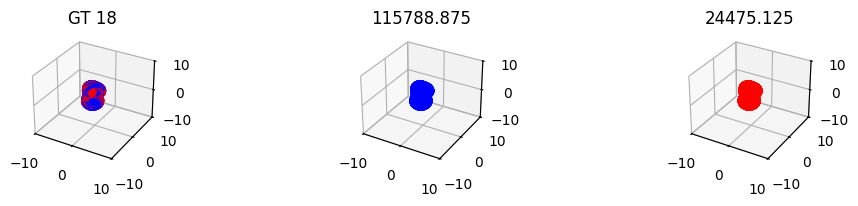

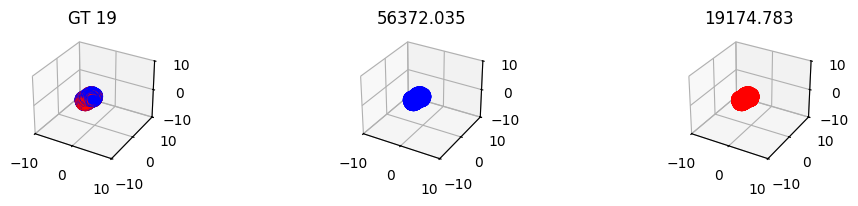

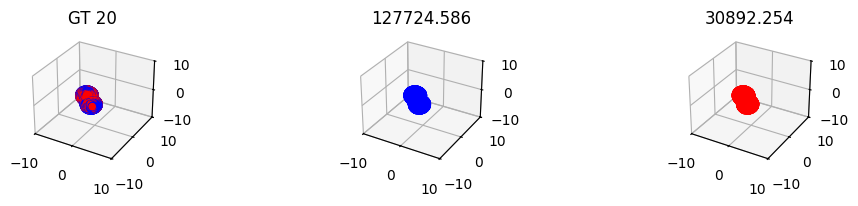

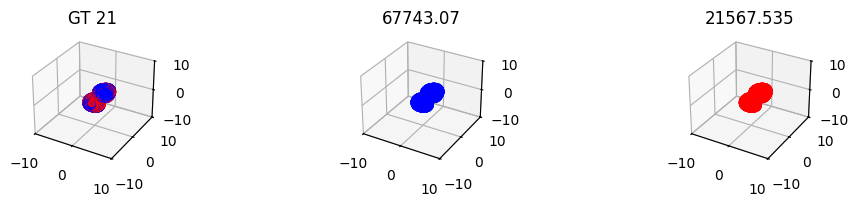

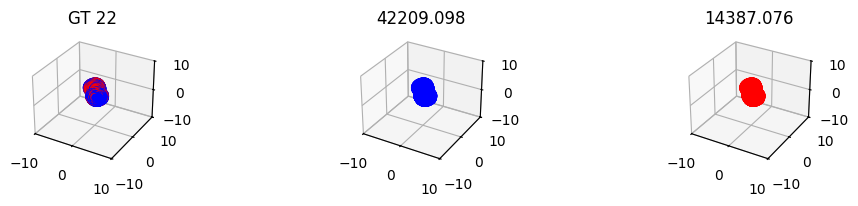

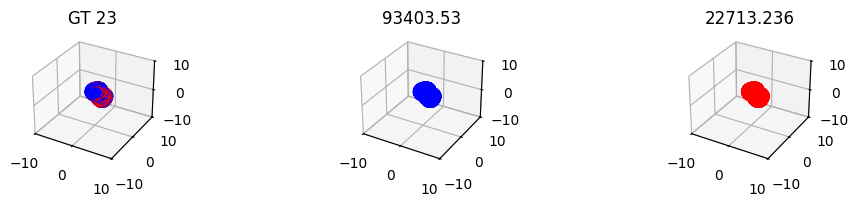

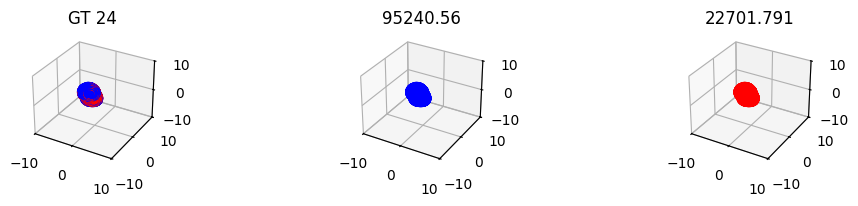

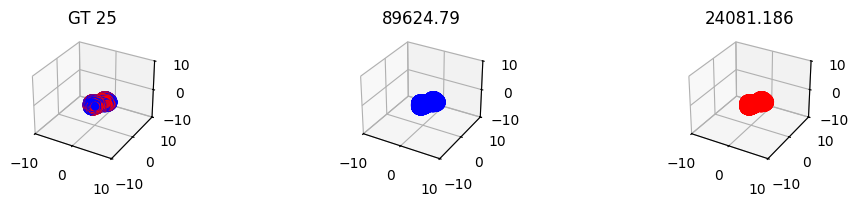

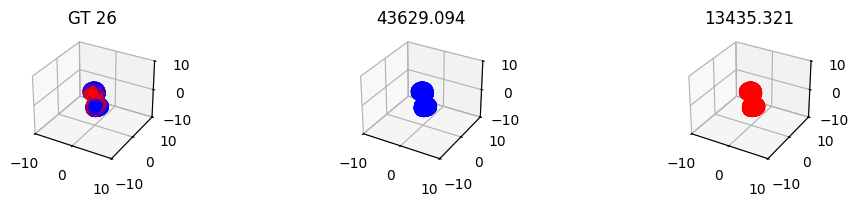

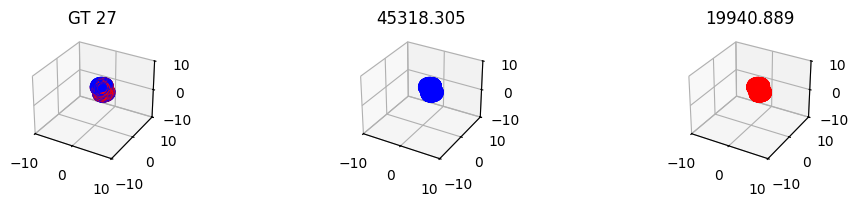

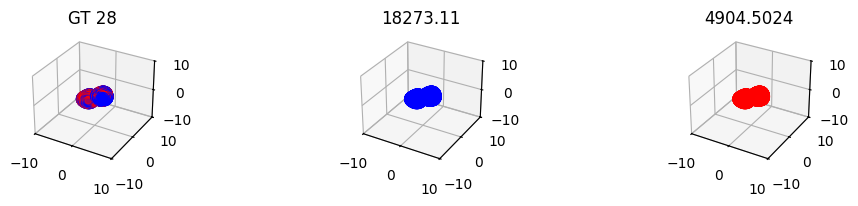

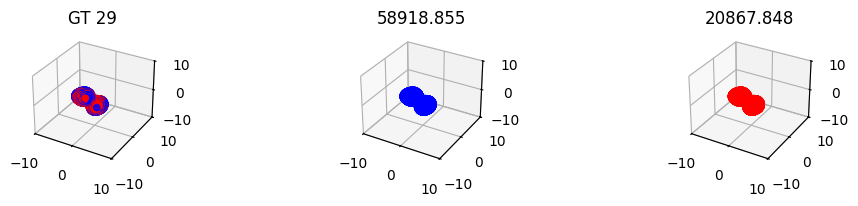

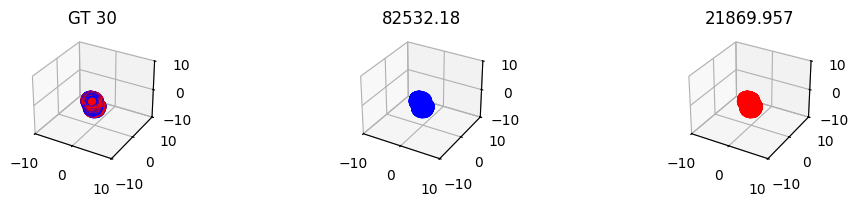

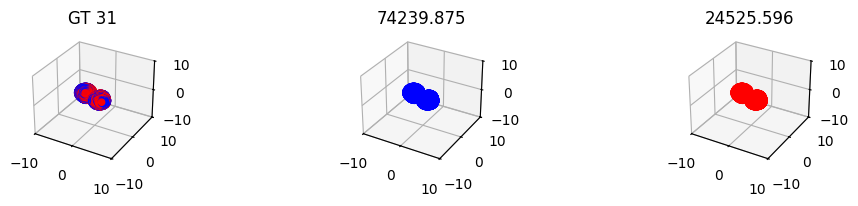

In [167]:
for batchID in range(1):
    batch = valid_batches[batchID]
    batch["mono"] = batch["mono"] * 1.0
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size)

In [ ]:
i = 15

In [ ]:
a1_ = mono.reshape(batch_size, 60, 2)[i]
b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
c1_ = batch["mono"].reshape(batch_size, 60)[i]
nonzero = np.nonzero(c1_)

for j, l, k in zip(a1_[nonzero], b1_[nonzero], c1_[nonzero]):
    print(j, j.sum(), l, k, )

dc = dipo.reshape(batch_size,60,3,2)
dc = np.moveaxis(dc, -1, -2)
dc = dc.reshape(batch_size, 120, 3)
dcq = mono.reshape(batch_size,120,1)
dcq = np.moveaxis(dcq, -1, -2)
dcq = dcq.reshape(batch_size, 120, 1)

In [ ]:
xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
from ase import Atoms
from ase.visualize import view
mol = Atoms(elem, xyz)
view(mol, viewer="x3d")

In [ ]:
idx = len(nonzero[0])*2
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
view(dcmol, viewer="x3d")

In [ ]:
combined = dcmol + mol
view(combined, viewer="x3d")

In [ ]:
train_batches = prepare_batches(data_key, train_data, batch_size)
print(len(train_batches))

In [ ]:
for batchID in range(1):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size)

In [ ]:
a1_ = mono.reshape(batch_size, 60, 2)[i]
b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
c1_ = batch["mono"].reshape(batch_size, 60)[i]
nonzero = np.nonzero(c1_)

for j, l, k in zip(a1_[nonzero], b1_[nonzero], c1_[nonzero]):
    print(j, j.sum(), l, k, )

dc = dipo.reshape(batch_size,60,3,2)
dc = np.moveaxis(dc, -1, -2)
dc = dc.reshape(batch_size, 120, 3)
dcq = mono.reshape(batch_size,120,1)
dcq = np.moveaxis(dcq, -1, -2)
dcq = dcq.reshape(batch_size, 120, 1)

In [ ]:
xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
from ase import Atoms
from ase.visualize import view
mol = Atoms(elem, xyz)
view(mol, viewer="x3d")

In [ ]:
idx = len(nonzero[0])*2
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
view(dcmol, viewer="x3d")

In [ ]:
combined = dcmol + mol
view(combined, viewer="x3d")

In [83]:
(dipo - batch['positions'][:,:,None]).reshape(batch_size, 60, 3, 2)[i]#[nonzero]

Array([[[ 6.96942583e-03,  1.29500359e-01],
        [-2.99999952e-01, -2.99999952e-01],
        [-3.00000012e-01, -3.00000012e-01]],

       [[ 3.00000012e-01, -2.34667584e-01],
        [-3.00000012e-01,  3.00000012e-01],
        [ 3.00000012e-01, -2.99999982e-01]],

       [[-3.00000012e-01, -3.00000012e-01],
        [ 3.00000012e-01,  3.00000012e-01],
        [-3.00000012e-01, -3.00000012e-01]],

       [[ 2.99999952e-01,  2.99999952e-01],
        [ 3.00000012e-01,  3.00000012e-01],
        [ 1.23798780e-01,  3.00000012e-01]],

       [[ 8.78653526e-02,  2.87826538e-01],
        [ 3.19617391e-02,  1.01698279e-01],
        [-3.86080891e-03,  1.07936375e-02]],

       [[-3.94368172e-03,  4.78768349e-03],
        [-1.87885761e-03,  1.34503841e-03],
        [ 6.30449504e-04,  1.39467791e-03]],

       [[-1.19948387e-03,  6.72340393e-04],
        [-3.24440002e-03,  3.30829620e-03],
        [ 3.79592180e-04, -5.99294901e-04]],

       [[-3.36313248e-03,  3.26728821e-03],
        [ 8.165240